In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.datasets as dsets
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

In [2]:
# GPU 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

print(device)

cuda


In [102]:
# parameters
learning_rate = 0.001
epochs = 25
batch_size = 100
drop_prob = 0.5

In [43]:
# 데이터 준비
mnist_train = dsets.MNIST(root='MNIST_data/', train = True, transform = transforms.ToTensor(), download = True)
mnist_test = dsets.MNIST(root='MNIST_data/', train = False, transform = transforms.ToTensor(), download = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 485102517.29it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 32328714.66it/s]


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 202449910.62it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 8034807.58it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [ ]:
# 데이터 전처리 x
mu = x_train.mean(dim=0)
sigma = x_train.std(dim=0)
x_train = (x_train-mu) / sigma
print(x_train)

tensor([[-1.0674, -0.3758, -0.8398],
        [ 0.7418,  0.2778,  0.5863],
        [ 0.3799,  0.5229,  0.3486],
        [ 1.0132,  1.0948,  1.1409],
        [-1.0674, -1.5197, -1.2360]], device='cuda:0')


In [ ]:
# 데이터 전처리 y
mu = y_train.mean(dim=0)
sigma = y_train.std(dim=0)
y_train = (y_train-mu) / sigma
print(y_train)

tensor([[-0.8284],
        [ 0.6104],
        [ 0.3924],
        [ 1.0901],
        [-1.2645]], device='cuda:0')


In [44]:
# 커스텀 데이터 정의 (외부 데이터 가져올 때, 데이터로더 이용)
class CustomDataset(Dataset):
    def __init__(self):
        self.x_data = mnist_train
        self.y_data = mnist_test

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx:int):
        x = torch.FloatTensor(self.x_data[idx])
        y = torch.FloatTensor(self.y_data[idx])

        return x, y

dataset = CustomDataset()

In [45]:
# 커스텀 데이터를 데이터 로더로 가져오기
dataloader = DataLoader(mnist_train, batch_size, shuffle=True, drop_last=True)

In [113]:
# 모델 만들기 (xavier 써보기)
class mnistClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(28*28, 256)
        self.linear2 = nn.Linear(256,256)
        self.linear3 = nn.Linear(256,10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)
        self.bn = nn.BatchNorm1d(256)

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.xavier_normal_(self.linear3.weight)

    def forward(self,x):
        x = self.bn(self.linear1(x))
        x = self.relu(x)
        x = self.dropout(x)
        x = self.bn(self.linear2(x))
        x = self.relu(x)
        x = self.dropout(x)
        return self.linear3(x)



In [114]:
# 모델 정의
model = mnistClassifier().to(device)

In [115]:
# 손실함수 정의, optimizer 정의
criterion = F.cross_entropy
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [116]:
# 학습 시키기
for epoch in range(1, epochs+1):
    avg_cost = 0
    for sample in dataloader:
        x, y = sample
        x = x.view(-1, 28*28).to(device)
        y = y.to(device)

        hypothesis = model(x)
        cost = criterion(hypothesis, y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        avg_cost += cost / len(dataloader)

    print('Epoch: {}, Cost{:.6f}'.format(epoch, avg_cost))

Epoch: 1, Cost0.454999
Epoch: 2, Cost0.243796
Epoch: 3, Cost0.198119
Epoch: 4, Cost0.164933
Epoch: 5, Cost0.153791
Epoch: 6, Cost0.140724
Epoch: 7, Cost0.129770
Epoch: 8, Cost0.120712
Epoch: 9, Cost0.111874
Epoch: 10, Cost0.108702
Epoch: 11, Cost0.103989
Epoch: 12, Cost0.098084
Epoch: 13, Cost0.095045
Epoch: 14, Cost0.089207
Epoch: 15, Cost0.088011
Epoch: 16, Cost0.085606
Epoch: 17, Cost0.082517
Epoch: 18, Cost0.080310
Epoch: 19, Cost0.076106
Epoch: 20, Cost0.077914
Epoch: 21, Cost0.075852
Epoch: 22, Cost0.071098
Epoch: 23, Cost0.071206
Epoch: 24, Cost0.069737
Epoch: 25, Cost0.069430


Accuracy: 0.970
실제: 3
예측: 3


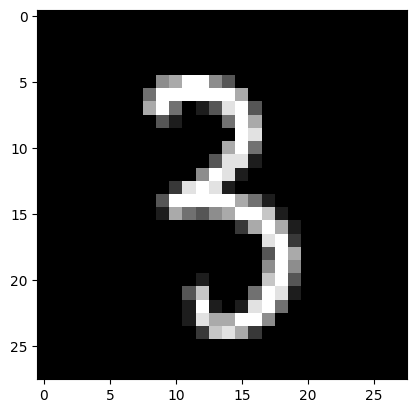

In [132]:
import random
import matplotlib.pyplot as plt
with torch.no_grad():
    x_test = mnist_test.test_data.view(-1,28*28).float().to(device)
    y_test = mnist_test.test_labels.to(device)

    prediction = model(x_test)
    correction = torch.argmax(prediction, 1)
    accuracy = (correction == y_test).float().mean()
    print('Accuracy: {:.3f}'.format(accuracy.item()))

    ex = random.randint(0, len(mnist_test))
    print('실제: {}'.format(y_test[ex]))
    print('예측: {}'.format(correction[ex]))

    ex_img = mnist_test.test_data[ex]
    plt.imshow(ex_img, cmap='gray')
    plt.show()
